In [1]:
%matplotlib inline

<b>Mid-circuit Measurements: Stepping Stone to Quantum Error Correction</b>

Fault-tolerent quantum computers are the holy grail of quantum computing. In this tutorial, you'll learn about a key ingredient in fault-tolerant quantum computation: <i>mid-circuit measurements</i> or MCMs. <br><br>
Typically, a quantum computation proceeds as follows:<br>
1. prepare some qubits in the $| 0 \rangle$ state, 
2. perform some gates on them, and 
3. measure the qubits in the computational basis.
<br>
<img src="standard_quantum_circuit.png" alt="Drawing" style="width: 300px;"/>
<br>    

With an MCM, we perform a measurement in the middle of step 2. That is, we do some gates, measure some of the qubits, and then do more gates.<br>

<img src="quantum_circuit_with_MCM.png" alt="Drawing" style="width: 300px;"/>
<br>   
At first glance, MCMs might not seem that important. But they are. Perhaps the biggest reason why is quantum error correction: the process of using extra qubits to detect and correct the errors that happen in quantum computers. Error correction is essential to making fault-tolerant quantum computers that can solve important real-world problems. And MCMs are a vital part of quantum error correction. Now that you know why MCMs matters, let’s dive in!

<b>Toy example of an MCM</b> <br>
In PennyLane, a mid-circuit measurement is done using <a href="https://docs.pennylane.ai/en/stable/code/api/pennylane.measure.html">qml.measure()</a>.
Let’s see it in action in a simple example with a single qubit. Consider the following sequence of operations: <br>
1. Rotate the qubit by an angle of $\pi/3$ about the y axis.<br> This evolves the state from the initial state $|0\rangle$ to $\frac{\sqrt{3}}{2} |0\rangle + \frac{1}{2} |1\rangle$<br>
2. Perform a mid-circuit measurement on the qubit in the computational basis.<br> This destroys the pure state and evolves it to the mixed state $\rho = \frac{3}{4} |0\rangle \langle 0| + \frac{1}{4} |1\rangle \langle 1|$. <br>
3. Perform a Pauli-$X$ gate on the qubit.<br>This evolves the state to $\rho = \frac{1}{4} |0\rangle \langle 0| + \frac{3}{4} |1\rangle \langle 1|$<br> 
4. Measure the expectation value of the qubit in the computational basis.
<br>


The expectation value of Z is: -0.50


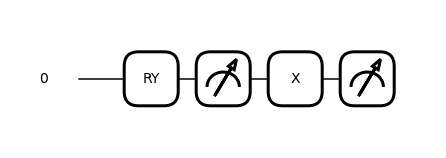

In [2]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device('default.qubit',wires=1) 

@qml.qnode(dev)
def circuit():
    qml.RY(np.pi/3,wires=0)
    qml.measure(wires=0)
    qml.PauliX(wires=0)
    return qml.expval(qml.PauliZ(0))

qml.draw_mpl(circuit)()

print(f"The expectation value of Z is: {circuit():.2f}")

The expectation value of $Z$ is -0.5 as (1/4) (+1) + (3/4) (-1) = -0.5.

<b>Conditional Operations</b><br>
At this point, you might be wondering what the use of MCMs is. How do they make quantum computations better? To answer this question, let's introduce the idea of a conditional operation. That is, making an MCM and only performing some other operation <i>if</i> the measurement result is a certain value. This is illustrated below.<br>
<img src="conditional_operation.png" alt="Drawing" style="width: 300px;"/>
<br>
The double lines from the MCM to the red square represent performing some gate on the middle qubit <i>if</i> the result of the MCM is some particular value (e.g., +1). 
<br>

Let’s look at a concrete example of a conditional operation. Consider the following sequence of operations performed on two qubits:<br>
1. Perform a Hadamard gate on the first qubit. This evolves the state from the initial state $|0\rangle|0\rangle$ to $\frac{1}{\sqrt{2}} \left( |0\rangle |0\rangle + |1\rangle |0\rangle \right)$<br>
2. Perform a mid-circuit measurement on the first qubit. The state evolves to the mixed state $\rho = \frac{1}{2} \left( |00\rangle \langle 00| + |10\rangle \langle 10| \right)$ <br>
3. If we measure the state |1>, then perform a Pauli-$X$ gate on the second qubit. If we measure the state |0>, then do nothing.
This evolves the state to $\rho = \frac{1}{2} \left( |00\rangle \langle 00| + |11\rangle \langle 11| \right)$.<br>
4. Measure the expectation value of $Z_{0} Z_{1}$.

In PennyLane, conditional operations are done using <a href= "https://docs.pennylane.ai/en/stable/code/api/pennylane.cond.html"> qml.cond()<a/>

The expectation value of Z_0 Z_1 is: 1.00


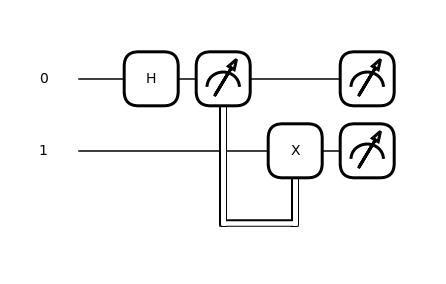

In [3]:
dev2 = qml.device('default.qubit',wires=2) 

@qml.qnode(dev2)
def conditional_circuit():
    qml.Hadamard(wires=0)
    mcm = qml.measure(wires=0)
    qml.cond(mcm,qml.PauliX)(wires=1)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

qml.draw_mpl(conditional_circuit)()

print(f"The expectation value of Z_{0} Z_{1} is: {conditional_circuit():.2f}")

The final measurement result is +1 as $|00 \rangle \langle 00 |$ gives $Z_{0}Z_{1} = (+1)(+1) =+1$ and $|11 \rangle \langle 11 |$ gives $Z_{0}Z_{1} = (-1)(-1) =+1$.

<b>Quantum Error Correction</b><br>
Still not impressed? Let’s go deeper and see how you can use MCMs to help implement quantum error correction.

Quantum error correction starts by encoding a qubit into across multiple qubits. Here’s an example:

$|0>_{L} = |000>$

$|1>_{L} = |111>$

The $L$ subscripts stand for “logical” and represent the fact that the two states are logical qubit states. 

In [4]:
import numpy as np

dev3 = qml.device("default.mixed",wires=5)

#parameters that define the initial qubit state that we want to protect against errors
alpha = 1/(2**0.5) 
beta = 1/(2**0.5)

state = np.array([alpha,beta])

#Encode the qubit across three physical qubits
def logical_encoding(state):
    qml.QubitStateVector(state,wires=0)
    qml.CNOT([0,1])
    qml.CNOT([1,2])

The error correction code that we'll talk about protects against errors that flip the states of qubits from $| 0 \rangle$ to $|1\rangle$ and vice-versa. They're called bit-flip errors.  Let’s consider the simplified case where we only have bit flip errors on the second and third qubits (i.e., qubits 1 and 2) &nbsp; [1]. They each occur with a probability of $p$. (Later on, we’ll set $p$ to 0.05.) We can implement them using PennyLane’s <a href ="https://docs.pennylane.ai/en/stable/code/api/pennylane.BitFlip.html"> BitFlip class</a>:

In [5]:
def BitFlipErrorChannel(p):
    qml.BitFlip(p,wires=1)
    qml.BitFlip(p,wires=2)
    

Finally, let’s define the complete circuit that implements the error correction.

In [6]:
@qml.qnode(dev3)
def circuit(state,p):
    logical_encoding(state)
    BitFlipErrorChannel(p)

    #perform CNOTs that help detect which qubit has a bitflip error
    qml.CNOT([0,3])
    qml.CNOT([1,3])
    
    qml.CNOT([0,4])
    qml.CNOT([2,4])
    
    mcm_ancilla_0 = qml.measure(3)
    qml.cond(mcm_ancilla_0,qml.PauliX)(1)

    mcm_ancilla_1 = qml.measure(4)
    qml.cond(mcm_ancilla_1,qml.PauliX)(2)

    return qml.probs([0,1,2])

The first MCM is on qubit 3. If it measures $| 1 \rangle$, we know that a bit-flip error occurred on qubit 1. So, we perform a conditional Pauli-$X$ gate on qubit 1 if the MCM yields $| 1 \rangle$. The second MCM works in the same way---except that it's on qubit 4 and we perform a conditional Pauli-$X$ gate on qubit 2. (For the full details on why the scheme works, see Section IV of &nbsp; [1].)

And, now, let’s actually run the circuit!

In [7]:
c = circuit(state,0.05)

for i in range(8):
    print(f"The probability of measuring {i:03b} is {c[i]:.3f}")

The probability of measuring 000 is 0.500
The probability of measuring 001 is 0.000
The probability of measuring 010 is 0.000
The probability of measuring 011 is 0.000
The probability of measuring 100 is 0.000
The probability of measuring 101 is 0.000
The probability of measuring 110 is 0.000
The probability of measuring 111 is 0.500


Let's compare these results to the original logical-qubit state of $\frac{1}{\sqrt{2}} \left( |000\rangle + |111\rangle \right)$:

In [8]:
@qml.qnode(dev3)
def initial_state_circuit(state):
    logical_encoding(state)
    return qml.probs([0,1,2])

d = initial_state_circuit(state)

for i in range(8):
    print(f"The probability of measuring {i:03b} is {d[i]:.3f}")

The probability of measuring 000 is 0.500
The probability of measuring 001 is 0.000
The probability of measuring 010 is 0.000
The probability of measuring 011 is 0.000
The probability of measuring 100 is 0.000
The probability of measuring 101 is 0.000
The probability of measuring 110 is 0.000
The probability of measuring 111 is 0.500


As you can see, the probabilities of the states $|000\rangle$ and $|111\rangle$ in both circuits are 0.5. This shows that the error correction scheme works. 

<b>Conclusion</b><br>
In this demo, you've learnt that:<br>
-  You can perform mid-circuit measurements (MCMs) using qml.measure<br>
-  You can perform an operation conditioned on the result of an MCM using qml.cond<br>
-  You can use MCM's (and conditional operations) to help implement quantum error correction in fault-tolerant quantum computers.
<br>


<b>Note</b><br>
The images in this notebook have been adapted from PennyLane's <a href="https://pennylane.ai/qml/demos/tutorial_measurement_optimize/">Measurement Optimization</a> tutorial.
<br>

<b>References</b><br>
[1] The error correction scheme discussed is a simplified version of the full scheme in Section IV of Simon J. Devitt, Kae Nemoto, William J. Munro, "Quantum Error Correction for Beginners", Rep. Prog. Phys. 76 (2013) 076001 and <a href="https://arxiv.org/abs/0905.2794"> arXiv:0905.2794</a>